<br/>
$$ \huge{\underline{\textbf{ 2-Layer Neural Network }}} $$
<br/>

Contents:
* [Introduction](#Introduction)
* [Load and Explore Data](#Load-and-Explore-Data)
* [Preprocess](#Preprocess)
* [Neural Network](#Neural-Network)
* [Train Estimator](#Train-Estimator)

# Introduction

This notebook shows very simple 2-layer neural network for regression

**Dataset**

We will use bicycle sharing dataset ([https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)). Dataset is from bike sharing system, containing hourly breakout of how many bikes were rented as well as weather conditions, if day is holiday or not etc. Our task is to predict amount of bikes rented based on input features. Features are described behind the link.

**Model**

* preprocessing:
  * one-hot encode categorical features
  * normalize continous features
* 1st layer: fully connected with sigmoid activation 
* 2nd (output) layer: fully connected _with no activation_
* loss: MSE
* optimizer: vanilla SGD

**Dependencies**

* numpy and matplotlib
* pandas

# Load and Explore Data

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load data

In [2]:
df = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

Show first couple hours

In [3]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Plot amount of bikes rented in first 10 days (240 hours)

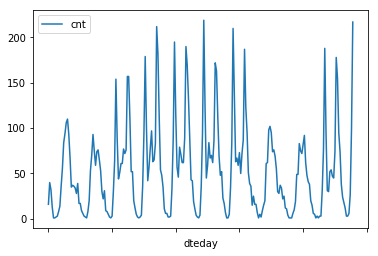

In [4]:
df[:240].plot(x='dteday', y='cnt')

You can see spikes in the morning and evening, persumably due to increased demand during commute time.

# Preprocess

Convert categorical features (like season) into one-hot encoded 'dummies'. Then drop these features along some of the features we wont use.

In [5]:
data = df.copy()
for field in ['season', 'weathersit', 'mnth', 'hr', 'weekday']:
    onehot = pd.get_dummies(data[field], prefix=field, drop_first=False)
    data = pd.concat([data, onehot], axis=1)

# Drop fields
fields_to_drop = ['season', 'weathersit', 'mnth', 'hr', 'weekday',
                  'instant', 'dteday', 'atemp', 'workingday']
data = data.drop(fields_to_drop, axis=1)

Show data after conversions

In [6]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Normalize continous features

In [7]:
for field in ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']:
    mean, std = data[field].mean(), data[field].std()
    data.loc[:, field] = (data[field] - mean)/std

Split to training/validation/test sets

In [8]:
# Convert to numpy
features = data.drop(['cnt', 'casual', 'registered'], axis=1).values
targets = data['cnt'].values[:,None]

N_t = len(features)
train_x, valid_x, test_x = np.split(features, [int(N_t*0.88815), int(N_t*0.971)])
train_y, valid_y, test_y = np.split(targets, [int(N_t*0.88815), int(N_t*0.971)])
train_i = np.array(range(len(train_x)))  # index, used for random batch sampling

In [9]:
print('train', train_x.shape, train_y.shape)
print('valid', valid_x.shape, valid_y.shape)
print('test', test_x.shape, test_y.shape)

train (15435, 56) (15435, 1)
valid (1440, 56) (1440, 1)
test (504, 56) (504, 1)


# Neural Network

Sigmoid and derivative

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

Forward pass, note there is _no acitivation function in output layer_. This is because we are doing regression, so output must be able to match any range, not only [0..1].

In [11]:
def fwd(x, W_hid, W_out):
    assert x.ndim == 2
    assert W_hid.ndim == 2
    assert W_out.ndim == 2

    z_hid = x @ W_hid 
    h_hid = sigmoid(z_hid)                              # hidden output

    z_out = h_hid @ W_out
    y_hat = z_out                                       # linear output

    return y_hat, z_hid, h_hid                          # z_hid and h_hid required for backprop

MSE Loss

In [12]:
def MSE(y, y_hat):                                      # no innner sum, 
    return np.mean((y-y_hat)**2)                        # becouse only one output column

Backprop, note again that there is no activation in output layer

In [13]:
def backprop(x, y, W_hid, W_out):
    assert x.ndim == 2
    assert y.ndim == 2
    assert W_hid.ndim == 2
    assert W_out.ndim == 2
    
    y_hat, z_hid, h_hid = fwd(x, W_hid, W_out)
    
    ro_out = -(y-y_hat)                                 # no transfer function
    dW_out = h_hid.T @ ro_out
    
    ro_hid = (ro_out @ W_out.T) * sigmoid_deriv(z_hid)
    dW_hid = x.T @ ro_hid
    
    return dW_hid, dW_out, y_hat

# Train Estimator

Hyperparameters

In [14]:
n_in = 56
n_hid = 12
n_out = 1
lr = 0.95
n_batch = 128
iterations = 1500

Initialize weights with Xavier

In [15]:
np.random.seed(0)

# Initialize weights
W_hid = np.random.normal(0.0, n_in**-.5, [n_in, n_hid])
W_out = np.random.normal(0.0, n_hid**-.5, [n_hid, n_out])

Train loop. Note that most of the time you want to iterate whole dataset (in random order), only then re-shuffle and iterate again. Here we skip that and just sample randomly from whole dataset.

In [16]:
losses = {'train':[], 'valid':[]}                        # keep history for plotting
for i in range(iterations):
    
    # Get mini-batch, both as 2d arrays
    batch = np.random.choice(train_i, n_batch)
    x = train_x[batch]
    y = train_y[batch]
    
    # Learning step
    dW_hid, dW_out, y_hat = backprop(x, y, W_hid, W_out)
    W_hid += -lr * dW_hid / n_batch                      # Apply gradient
    W_out += -lr * dW_out / n_batch
    
    # Keep train loss (on mini-batch) and calculate validation loss
    train_loss = MSE(y, y_hat)
    losses['train'].append(train_loss)
    valid_y_hat, _, _ = fwd(valid_x, W_hid, W_out)
    valid_loss = MSE(valid_y, valid_y_hat)
    losses['valid'].append(valid_loss)

Plot learning curves

(0, 2)

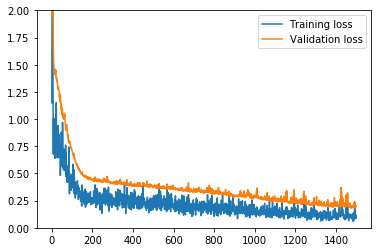

In [17]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['valid'], label='Validation loss')
plt.legend()
plt.ylim(0, 2)

**Quick Regression Test**

In [18]:
correct_W_hid_part = \
    np.array([[ 0.13977837,  0.39589006, -0.44433984, -0.23372222, -0.32673332, -0.31501645,
                1.33654143, -0.66407594, -0.532159  , -0.42685932,  0.27269841, -0.03363818],
              [ 0.48351939, -1.12272939,  0.13089203, -0.06550705,  0.17449842, -0.12881516,
               -0.66353395, -0.07265479, -0.007572  , -0.0190456 , -0.10529271, -0.27215422],
              [ 0.20766098,  0.50374951, -0.47341402, -0.18073073, -0.22643633,  0.372545  ,
                0.16996664, -0.26835636, -1.22899995, -0.3707829 ,  0.50471608, -0.19382687],
              [ 0.12652124, -0.07856539,  0.03382242, -0.10831552, -0.02563025, -0.32419792,
                0.00803561,  0.48387678, -0.48559138, -0.17401633, -0.32882098,  0.01550563]])
assert np.allclose(W_hid[0:4], correct_W_hid_part)

Correct output:
```
array([[ 0.13977837,  0.39589006, -0.44433984, -0.23372222, -0.32673332,
        -0.31501645,  1.33654143, -0.66407594, -0.532159  , -0.42685932,
         0.27269841, -0.03363818],
       [ 0.48351939, -1.12272939,  0.13089203, -0.06550705,  0.17449842,
        -0.12881516, -0.66353395, -0.07265479, -0.007572  , -0.0190456 ,
        -0.10529271, -0.27215422],
       [ 0.20766098,  0.50374951, -0.47341402, -0.18073073, -0.22643633,
         0.372545  ,  0.16996664, -0.26835636, -1.22899995, -0.3707829 ,
         0.50471608, -0.19382687],
       [ 0.12652124, -0.07856539,  0.03382242, -0.10831552, -0.02563025,
        -0.32419792,  0.00803561,  0.48387678, -0.48559138, -0.17401633,
        -0.32882098,  0.01550563]])
```